C:\Users\gaugo01\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2903: DtypeWarning: Columns (11,12,31) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


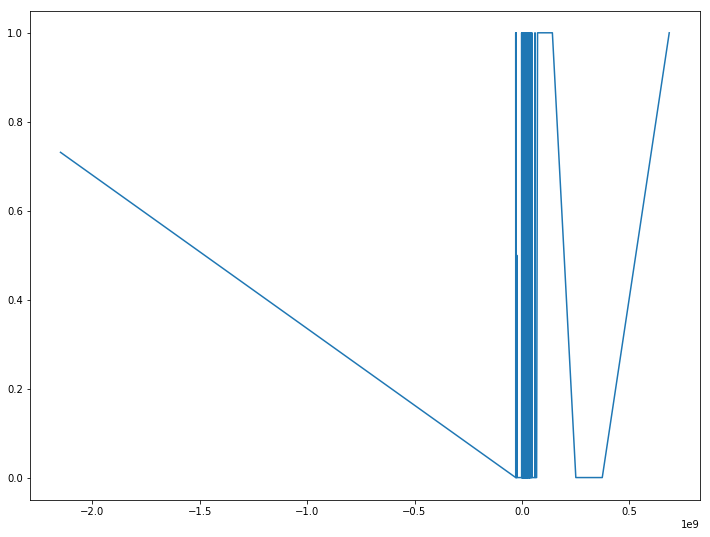

In [55]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import category_encoders as ce

X_train_temp = pd.DataFrame()

def preprocess_data():
    # ***read from the dataset files***
    blight_df = pd.read_csv('train.csv', encoding='ISO-8859-1', index_col='ticket_id')
    # X_test = pd.read_csv('test.csv', encoding='ISO-8859-1', index_col='ticket_id')
    addr_df = pd.read_csv('addresses.csv', index_col='ticket_id')
    latlons_df = pd.read_csv('latlons.csv', index_col='address')

    # ***remove unnecessary columns for now***
    blight_df.drop(['agency_name', 'inspector_name', 'violation_street_name', 'violation_zip_code',
                    'mailing_address_str_number', 'mailing_address_str_name', 'city', 'state', 'zip_code',
                    'non_us_str_code', 'country', 'violation_description', 'payment_amount', 'payment_date',
                    'payment_status', 'balance_due', 'collection_status', 'admin_fee', 'state_fee',
                    'clean_up_cost', 'compliance_detail', 'violator_name', 'fine_amount'],
                   axis=1, inplace=True)
    # ***removing columns where compliance is blank***
    blight_df = blight_df[blight_df['compliance'].isin([0.0, 1.0])]
    blight_df['compliance'] = blight_df['compliance'].astype(int)

    # ***removing blank columns***
    blight_df.dropna(axis=1, how='all', inplace=True)

    # ***adding new column gap_ticket_hear which is the gap in seconds between ticket issue data
    #    & hearing date and removing ticket issue date and hearing date***
    blight_df['ticket_issued_date'] = pd.to_datetime(blight_df['ticket_issued_date'])
    blight_df['hearing_date'] = pd.to_datetime(blight_df['hearing_date'])
#     print(blight_df.describe(include='all'))
    blight_df['gap_ticket_hear'] = blight_df['hearing_date'] - blight_df['ticket_issued_date']
    blight_df.drop(['ticket_issued_date', 'hearing_date'], axis=1, inplace=True)
    blight_df['gap_ticket_hear'] = (blight_df['gap_ticket_hear'].astype(np.int64)) / 10 ** 9
    blight_df['gap_ticket_hear'] = blight_df['gap_ticket_hear'].astype(int)
    gap_comp = (blight_df[['gap_ticket_hear', 'compliance']].groupby('gap_ticket_hear',
                                                                     as_index=False)
                                                            .apply(np.mean))
    plt.figure(1, figsize=(12,9))
    plt.plot(gap_comp['gap_ticket_hear'], gap_comp['compliance'])
    
    # ***order the columns***
    cols = list(blight_df.columns)
    cols = cols[:2] + cols[-1:] + cols[2:-1]

    # ***train_test_split***
    X_train = blight_df[cols[:-1]]
    y_train = blight_df[cols[-1]]
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, random_state=0)

    # ***Merging the training data with address file and latitude and longitude files to include lat
    # and lon columns and remove address and violation street number for both train and test data***
    X_train = X_train.merge(addr_df, how='left', left_index=True, right_index=True)
    X_train = X_train.merge(latlons_df, left_on='address',
                            right_index=True, how='left')  # check how the desired cols after merging
    X_train['lat'].fillna(X_train['lat'].mean(), inplace=True)
    X_train['lon'].fillna(X_train['lon'].mean(), inplace=True)
    X_train.drop(['address', 'violation_street_number'], axis=1, inplace=True)

    X_test = X_test.merge(addr_df, how='left', left_index=True, right_index=True)
    X_test = X_test.merge(latlons_df, left_on='address', right_index=True, how='left')
    X_test['lat'].fillna(X_train['lat'].mean(), inplace=True)
    X_test['lon'].fillna(X_train['lon'].mean(), inplace=True)
    X_test.drop(['violation_street_number', 'address'], axis=1, inplace=True)

    # ***Concatenating training and test data for encoding the categorical values***
    x_train_len = len(X_train)
    X_train = pd.concat([X_train, X_test], sort=False)
    global X_train_temp
    X_train_temp = X_train.copy()
    # ***Doing the binary encoding of the categorical fields violation code and disposition***
    bin_encode = ce.BinaryEncoder(cols=['violation_code', 'disposition'])
    X_train = bin_encode.fit_transform(X_train)
    X_train.drop('violation_code_0', axis=1, inplace=True)
    X_test = X_train.iloc[x_train_len:, :]
    X_train = X_train.iloc[:x_train_len, :]
    
    cols = [cols for cols in X_train.columns if ('viol' not in cols and 'disp' not in cols)]
    st_sc = StandardScaler()
    X_train[cols] = st_sc.fit_transform(X_train[cols])
    rows = ((X_train > 3.0) | (X_train < -3.0)).any(axis=1)
    X_train = X_train[~rows]
    y_train = y_train[~rows]
    
    X_test[cols] = st_sc.transform(X_test[cols])

    return X_train, X_test, y_train, y_test


if __name__ == '__main__':
    X_train, X_test, y_train, y_test = preprocess_data()
    X_train.to_csv('X_train.csv')
    X_test.to_csv('X_test.csv')
    y_train.to_csv('y_train.csv')
    y_test.to_csv('y_test.csv')


In [30]:
X_train, X_test, y_train, y_test = preprocess_data()

C:\Users\gaugo01\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2903: DtypeWarning: Columns (11,12,31) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [26]:
X_train_temp.describe()

,gap_ticket_hear,late_fee,discount_amount,judgment_amount,lat,lon
count,1.598800e+05,159880.000000,159880.000000,159880.000000,159880.000000,159880.000000
mean,3.257894e+06,33.651512,0.195959,420.650218,42.389747,-83.111530
std,8.127900e+07,67.692916,4.290344,742.555062,0.037120,0.093515
min,-2.147484e+09,0.000000,0.000000,0.000000,42.145257,-84.403766
25%,2.675400e+06,10.000000,0.000000,250.000000,42.364537,-83.185854
50%,4.687200e+06,25.000000,0.000000,305.000000,42.392575,-83.124517
75%,8.658600e+06,25.000000,0.000000,305.000000,42.419160,-83.033202
max,6.854742e+08,1000.000000,350.000000,11030.000000,44.785389,-82.512936


In [49]:
X_train_temp.dtypes

violation_code      object
gap_ticket_hear      int32
disposition         object
late_fee           float64
discount_amount    float64
judgment_amount    float64
lat                float64
lon                float64
dtype: object

In [53]:
X_train_temp.describe(include='all')

,violation_code,gap_ticket_hear,disposition,late_fee,discount_amount,judgment_amount,lat,lon
count,159880,1.598800e+05,159880,159880.000000,159880.000000,159880.000000,159880.000000,159880.000000
unique,189,NaN,4,NaN,NaN,NaN,NaN,NaN
top,9-1-36(a),NaN,Responsible by Default,NaN,NaN,NaN,NaN,NaN
freq,64414,NaN,138340,NaN,NaN,NaN,NaN,NaN
mean,NaN,3.257894e+06,NaN,33.651512,0.195959,420.650218,42.389747,-83.111530
std,NaN,8.127900e+07,NaN,67.692916,4.290344,742.555062,0.037120,0.093515
min,NaN,-2.147484e+09,NaN,0.000000,0.000000,0.000000,42.145257,-84.403766
25%,NaN,2.675400e+06,NaN,10.000000,0.000000,250.000000,42.364537,-83.185854
50%,NaN,4.687200e+06,NaN,25.000000,0.000000,305.000000,42.392575,-83.124517
75%,NaN,8.658600e+06,NaN,25.000000,0.000000,305.000000,42.419160,-83.033202


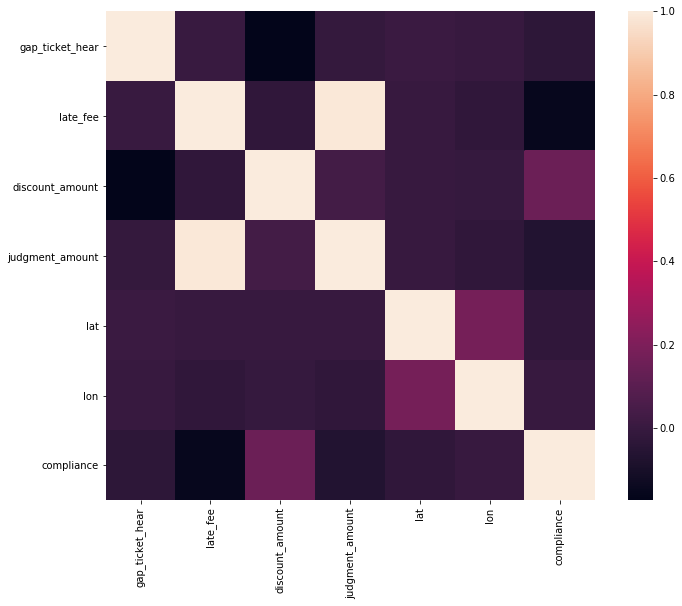

In [36]:
f, ax = plt.subplots(figsize=(12,9))
dataset = pd.concat([X_train_temp, y_train], axis=1)
sns.heatmap(dataset.corr(), square=True)